In [151]:
%load_ext autoreload
%autoreload 2

import rlpg.envs.cars as cars
import rlpg.models.vae as vae
import rlpg.envs.types as rl_envs
import rlpg.models.common as models
import rlpg.utils as rl_utils
import rlpg.loaders as rl_loaders

import gymnasium as gym
import torchvision.transforms.functional as ttf
import torchvision.transforms as tt

import os
import matplotlib.pyplot as plt
import torch.utils.tensorboard
import numpy as np
import utils
from typing import Tuple, List
import pathlib
import tqdm
import random
import lightning
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
def generate_vae_images (
    out_dir: str, 
    episodes: int, 
    max_episode_steps: int, 
    size: Tuple[int, int],
    agressive_odds: float = 0.95,
    skip_start_odds: float = 0.1,
    include_bar: bool = False,
    grayscale: bool = False
):
    out_dir = pathlib.Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    img_idx = 0

    renderopts = None
    if not include_bar:
        renderopts = rl_envs.RenderOptions(size, color=not grayscale, crop_size=(1, 0.87))
    else:
        renderopts = rl_envs.RenderOptions(size, color= not grayscale)
    
    env, _, _ = cars.car_basic(skip_start=True)
    for i in tqdm.tqdm(range(episodes)):
        env.reset()
        ep_step = 0
        skip_start = random.random() < skip_start_odds
        agressive = random.random() > agressive_odds
        while True:
            action = env.action_space.sample()
            action[2] = 0.0
            if agressive:
                action *= 5
            obs, _, terminated, _, _ = env.step(action)
            if terminated or ep_step > max_episode_steps:
                break
            ep_step += 1

            if skip_start and ep_step < 40:
                continue
            
            img = rl_envs.apply_renderopts(obs, renderopts)
            img.save(out_dir / f"img{img_idx}.png")
            img_idx += 1

In [122]:
class VAEModule2D (lightning.LightningModule):
    def __init__(self, img_w, img_h, n_channels, hidden_size, latent_dims) -> None:
        super().__init__()
        self.model = vae.VariationalAutoencoder2D(
            img_w=img_w,
            img_h=img_h,
            in_channels=n_channels,
            hidden_size=hidden_size,
            latent_dims=latent_dims
        )
        self.latent_dims = latent_dims
        self.save_hyperparameters()
    
    def forward (self, x):
        x = x.to(self.device)
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x = batch
        x = x.to(self.device)
        xhat, kl = self.model(x)
        loss = torch.nn.functional.mse_loss(xhat, x) #+ kl

        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [152]:
color = True
domain_randomize = True
img_size = (50,50)
device = "mps"

color_str = 'color' if color else 'bw'
img_dir = f"/tmp/car_imgs_{color_str}_{img_size[0]}x{img_size[1]}"
if not os.path.isdir(img_dir):
    generate_vae_images(img_dir, 200, 300, img_size, grayscale=not color)

print(f"Training VAE with {len(os.listdir(img_dir))} images")

channels = 3 if color else 1
loader = rl_loaders.image_dataloader(img_dir)
vae_model = VAEModule2D(img_size[0], img_size[1], channels, 100, 50).to("mps")
vae_trainer = lightning.Trainer(max_epochs = 10)
vae_trainer.fit(model=vae_model, train_dataloaders=loader)

100%|██████████| 200/200 [06:27<00:00,  1.94s/it]
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                     | Params
---------------------------------------------------
0 | model | VariationalAutoencoder2D | 1.3 M 
---------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.093     Total estimated model params size (MB)


Training VAE with 56494 images


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


tensor(0.0058, device='mps:0', grad_fn=<MseLossBackward0>)


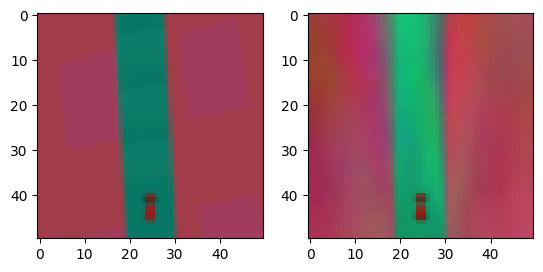

In [181]:
imglen = len(os.listdir(img_dir))
img_name = f"img{random.randint(0, imglen)}.png"
img = Image.open(os.path.join(img_dir, img_name))
imgt = ttf.pil_to_tensor(img).to(device).unsqueeze(0).float() / 255
imgt = imgt.to("mps")
vae_model.model.to("mps")
res, kl = vae_model.model(imgt)
print(torch.nn.functional.mse_loss(imgt, res))
res = res.squeeze(0).detach().cpu()
fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(ttf.to_pil_image(res))